# Demo | Specifying a Bayesian Model Demo | Qonto

- This notebook is used for reference in a series of articles on MMM - [see here](https://www.notion.so/qonto/v1-Marketing-Mix-Models-at-Qonto-Part-IV-Specifying-a-Bayesian-Model-with-PyMC-1f96f02ec80a4d619f4ef26e86d6603c?pvs=4)
- Note : the fictitous dataset used in this notebook was taken from [Project Robyn](https://github.com/facebookexperimental/Robyn/tree/main/R/data) and is not representative of Qonto's marketing activity

## Imports

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Scikit-learn
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

# MMM imports
import arviz as az
import pymc as pm
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.9.1


## Read the data

In [2]:
df = pd.read_csv('dt_simulated_weekly.csv', parse_dates = ['date'])
df.head()

,date,revenue,tv_s,ooh_s,print_s,facebook_i,search_clicks_p,search_s,competitor_sales_b,facebook_s,newsletter,event1,event2
0,2015-11-23,2.754372e+06,22358.346667,0.0,12728.488889,2.430128e+07,0.000000,0.000000,8125009,7607.132915,19401.653846,0,0
1,2015-11-30,2.584277e+06,28613.453333,0.0,0.000000,5.527033e+06,9837.238486,4133.333333,7901549,1141.952450,14791.000000,0,0
2,2015-12-07,2.547387e+06,0.000000,132278.4,453.866667,1.665159e+07,12044.119653,3786.666667,8300197,4256.375378,14544.000000,0,0
3,2015-12-14,2.875220e+06,83450.306667,0.0,17680.000000,1.054977e+07,12268.070319,4253.333333,8122883,2800.490677,2800.000000,0,0
4,2015-12-21,2.215953e+06,0.000000,277336.0,0.000000,2.934090e+06,9467.248023,3613.333333,7105985,689.582605,15478.000000,0,0


## Categorise your input data

In [3]:
# Group inputs
original_paid_features = sorted(['tv_s', 'ooh_s', 'print_s', 'facebook_s', 'search_s'])
original_organic_features = sorted(['newsletter'])
original_competitor_features = sorted(['competitor_sales_b'])
original_control_features = sorted(['event1', 'event2'])
EXCLUDED_FEATURES = sorted(['facebook_i', 'search_clicks_p'])

# Gather all inputs into 1 sorted list
all_original_features = sorted(original_paid_features +
                               original_organic_features + 
                               original_competitor_features +
                               original_control_features)

# Create a feature selection dict
# And to be able to access values with later on
FEATURES = {
    # Gather all inputs into 1 sorted list for logging
    "features_all_possible": all_original_features,
    
    # Remove any features that the user specified earlier
    "features_included": sorted(set(all_original_features) - set(EXCLUDED_FEATURES)),
    
    # Also log the excluded features
    "features_excluded": EXCLUDED_FEATURES,
    
    # Update relevant feature groups to exclude user-specified features
    "features_paid": sorted(set(original_paid_features) - set(EXCLUDED_FEATURES)),
    "features_organic": sorted(set(original_organic_features) - set(EXCLUDED_FEATURES)),
    "features_competitor": sorted(set(original_competitor_features) - set(EXCLUDED_FEATURES)),
    "features_control": sorted(set(original_control_features) - set(EXCLUDED_FEATURES))
} 


In [4]:
# Split into X and y
y = df.revenue.copy()

# X includes control variables, organic media, paid media, and seasonality/time features
X = df[FEATURES["features_included"]].copy()
X.index = df.date.copy()

## Scaling

In [5]:
# Scale control variables - these are exogenous and require a MinMax scaling
control_scaler = MinMaxScaler()
X[FEATURES["features_control"]] = control_scaler.fit_transform(X[FEATURES["features_control"]])

# Scale all media variables - these are exogenous too and require a MinMax scaling
paid_scaler = MinMaxScaler()
X[FEATURES["features_paid"]] = paid_scaler.fit_transform(X[FEATURES["features_paid"]])

# Remaining media features to scale
other_media_features = FEATURES["features_organic"] + FEATURES["features_competitor"]
other_media_scaler = MinMaxScaler()

X[other_media_features] = other_media_scaler.fit_transform(X[other_media_features])
# Then make competitor negative (it's >0 after scaling) so that it's forced to subtract from Revenue
# in our regression equation later
X.competitor_sales_b = X.competitor_sales_b * -1

# Also scale the target - the endogenous variable
endog_scaler = MaxAbsScaler()
y = endog_scaler.fit_transform(y.to_numpy().reshape(-1, 1)).flatten()

## Trend

In [6]:
# Create trend feature - just a linear feature scaled between 0 and 1
trend_feature = (X.index - X.index.min()) / (X.index.max() - X.index.min())
X["trend_feature"] = trend_feature

## Seasonality

In [7]:
# Speficy number of fourier modes to use for seasonality (higher is more volatile)
SEASONALITY_CONFIG = {
    # 10 is the default value set by Prophet for yearly seasonality
    "seasonality_n_order": 10
}

# Create fourier modes to represent seasonality in our data
# Scale day of year
periods = X.index.dayofyear / 365.25
# Create modes
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, SEASONALITY_CONFIG["seasonality_n_order"] + 1)
        for func in ("sin", "cos")
    },
    # Add date as index to concat with later
    index=X.index
)

# Save seasonality columns for model coords later
SEASONALITY_CONFIG["seasonality_features"] = fourier_features.columns

# Add seasonality to data
X = pd.concat([X, fourier_features], axis=1)

## Constructing a model

In [8]:
# Test and train split
X_train, X_test, y_train, y_test, unscaled_y_train, unscaled_y_test = train_test_split(X, 
                                                                                       y, 
                                                                                       df.revenue.to_numpy(),
                                                                                       test_size = 0.1, 
                                                                                       shuffle = False)

In [9]:
# Set seed for this cell
rng = np.random.default_rng(42)

# The data has two constant (not mutable) dimensions: channel (media/control/organic) and fourier mode (seasonality) 
# The "coordinates" are the unique values that these dimensions can take
coords = {"paid": FEATURES['features_paid'],
          "organic": FEATURES['features_organic'],
          "competitor": FEATURES['features_competitor'], 
          "control": FEATURES['features_control'], 
          "fourier_mode": np.arange(SEASONALITY_CONFIG["seasonality_features"].size),
         }

# Create model in context manager
# Specify model coordinates from before
with pm.Model(coords=coords) as mmm:

    ##### ---- Mutable Coords ------ ####
    # Add date as mutable coordinate - for out-of-sample prediction later on
    mmm.add_coord(name="date", values=X_train.index, mutable=True)

    
    ##### ---- Data Containers ------ ####
    # Create container for channel data
    paid_data = pm.MutableData(name = "paid_data", 
                                 value = X_train[FEATURES['features_paid']].to_numpy(),
                                 dims = ("date", "paid"))

    # Create container for organic data
    organic_data = pm.MutableData(name = "organic_data", 
                                  value = X_train[FEATURES['features_organic']].to_numpy(),
                                  dims = ("date", "organic"))    

    # Create container for competitor data
    competitor_data = pm.MutableData(name = "competitor_data", 
                                     value = X_train[FEATURES['features_competitor']].to_numpy(),
                                     dims = ("date", "competitor"))     
    
    # Create container for control data
    control_data = pm.MutableData(name = "control_data", 
                                 value = X_train[FEATURES['features_control']].to_numpy(),
                                 dims = ("date", "control"))
    
    # Create container for trend data
    trend_data = pm.MutableData(name = "trend_data", 
                                 value = X_train["trend_feature"].to_numpy(),
                                 dims = "date")
    
    # Create container for seasonality data
    seasonality_data = pm.MutableData(name = "seasonality_data", 
                                 value = X_train[SEASONALITY_CONFIG["seasonality_features"]].to_numpy(),
                                 dims = ("date", "fourier_mode"))
    
    # Create container for y_obs data
    # Instead of using pm.Normal directly for observed data,
    # use pm.MutableData to be able to update it later (for the test/train split)
    y_obs_data = pm.MutableData(name="y_obs_data", value=y_train.flatten(), dims="date")

    ##### ---- Define priors ------ ####
    ## prior for baseline intercept term
    intercept =  pm.HalfNormal("intercept", sigma=2)

    ## prior for beta coeffecients / regressors
    beta_paid_coeffs = pm.HalfNormal("beta_paid_coeffs", sigma=2, dims="paid")
    
    ## prior for beta organic coeffecients / regressors
    beta_organic_coeffs = pm.HalfNormal("beta_organic_coeffs", sigma=2, dims="organic") 
    
    ## prior for beta competitor coeffecient / regressor
    beta_competitor_coeffs = pm.HalfNormal("beta_competitor_coeffs", sigma=2, dims="competitor")   

    ## prior for beta control coeffecients / regressors
    beta_control_coeffs = pm.Normal("beta_control_coeffs", mu=0, sigma=2, dims="control")    
    
    ## prior for trend
    beta_trend = pm.Normal(name="beta_trend", mu=0, sigma=2)

    ## prior for seasonality
    beta_fourier = pm.Laplace(name="beta_fourier", mu=0, b=2, dims="fourier_mode")

    ## Geometric adstock prior
    geoad_param_paid = pm.Beta(f"geoad_param_paid", alpha=1, beta=2, dims="paid")
    geoad_param_organic = pm.Beta(f"geoad_param_organic", alpha=1, beta=2, dims="organic")   

    ## Logistic saturation prior
    sat_lam = pm.Gamma(f"sat_lam", alpha=3, beta=1, dims="paid")

    # prior for likelihood noise level (note : must be positive)
    sigma = pm.HalfNormal("sigma", sigma=0.5)
    

    ##### ----- Model Parameterisation ----- #####
    ##### ----- Specify deterministic variables that feed the outcome variable ----- #####

    ## PAID
    ## Adstocking with Geometric
    paid_adstock = pm.Deterministic(name="paid_adstock", 
                                    var=geometric_adstock(x=paid_data, alpha=geoad_param_paid, l_max=12),
                                    dims=("date", "paid"))   
    ## Saturation (Logistic Function) - only done for paid data
    paid_adstock_saturated = pm.Deterministic(name="paid_adstock_saturated",
                                             var=logistic_saturation(x=paid_adstock, lam=sat_lam),                                           
                                             dims=("date", "paid"))   
    # Contributions
    paid_contributions = pm.Deterministic(name="paid_contributions",
                                             var=paid_adstock_saturated * beta_paid_coeffs,
                                             dims=("date", "paid"))

    ## ORGANIC
    ## Adstocking with Geometric
    organic_adstock = pm.Deterministic(name="organic_adstock", 
                                       var=geometric_adstock(x=organic_data, alpha=geoad_param_organic, l_max=12),
                                       dims=("date", "organic"))    
    ## Contributions
    organic_contributions = pm.Deterministic(name="organic_contributions",
                                             var=organic_adstock * beta_organic_coeffs,
                                             dims=("date", "organic"))

    ## COMPETITOR - NOTE WE FORCED THIS NEGATIVE EARLIER DURING SCALING
    competitor_contributions = pm.Deterministic(name="competitor_contributions",
                                                var = competitor_data * beta_competitor_coeffs,
                                                dims=("date", "competitor")) 

    ## CONTROL
    control_contributions = pm.Deterministic(name="control_contributions",
                                             var=control_data * beta_control_coeffs,
                                             dims=("date", "control"))

    ## TREND
    trend = pm.Deterministic(name="trend", var = intercept + beta_trend * trend_data, dims="date")
    ## SEASONALITY
    seasonality = pm.Deterministic(name="seasonality", var=pm.math.dot(seasonality_data, beta_fourier), dims="date")
    
    # Expected value of outcome
    mu = pm.Deterministic(name = "mu",
                          var = paid_contributions.sum(axis=-1) + 
                                  organic_contributions.sum(axis=-1) +
                                  competitor_contributions.sum(axis=-1) + # this is negative
                                  control_contributions.sum(axis=-1) +
                                  trend + 
                                  seasonality,
                          dims="date")


    # Likelihood (sampling distribution) of observations
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_obs_data, dims="date")

    # Sample the prior
    mmm_prior_predictive = pm.sample_prior_predictive(samples=1000, random_seed=rng)

Sampling: [beta_competitor_coeffs, beta_control_coeffs, beta_fourier, beta_organic_coeffs, beta_paid_coeffs, beta_trend, geoad_param_organic, geoad_param_paid, intercept, sat_lam, sigma, y_obs]


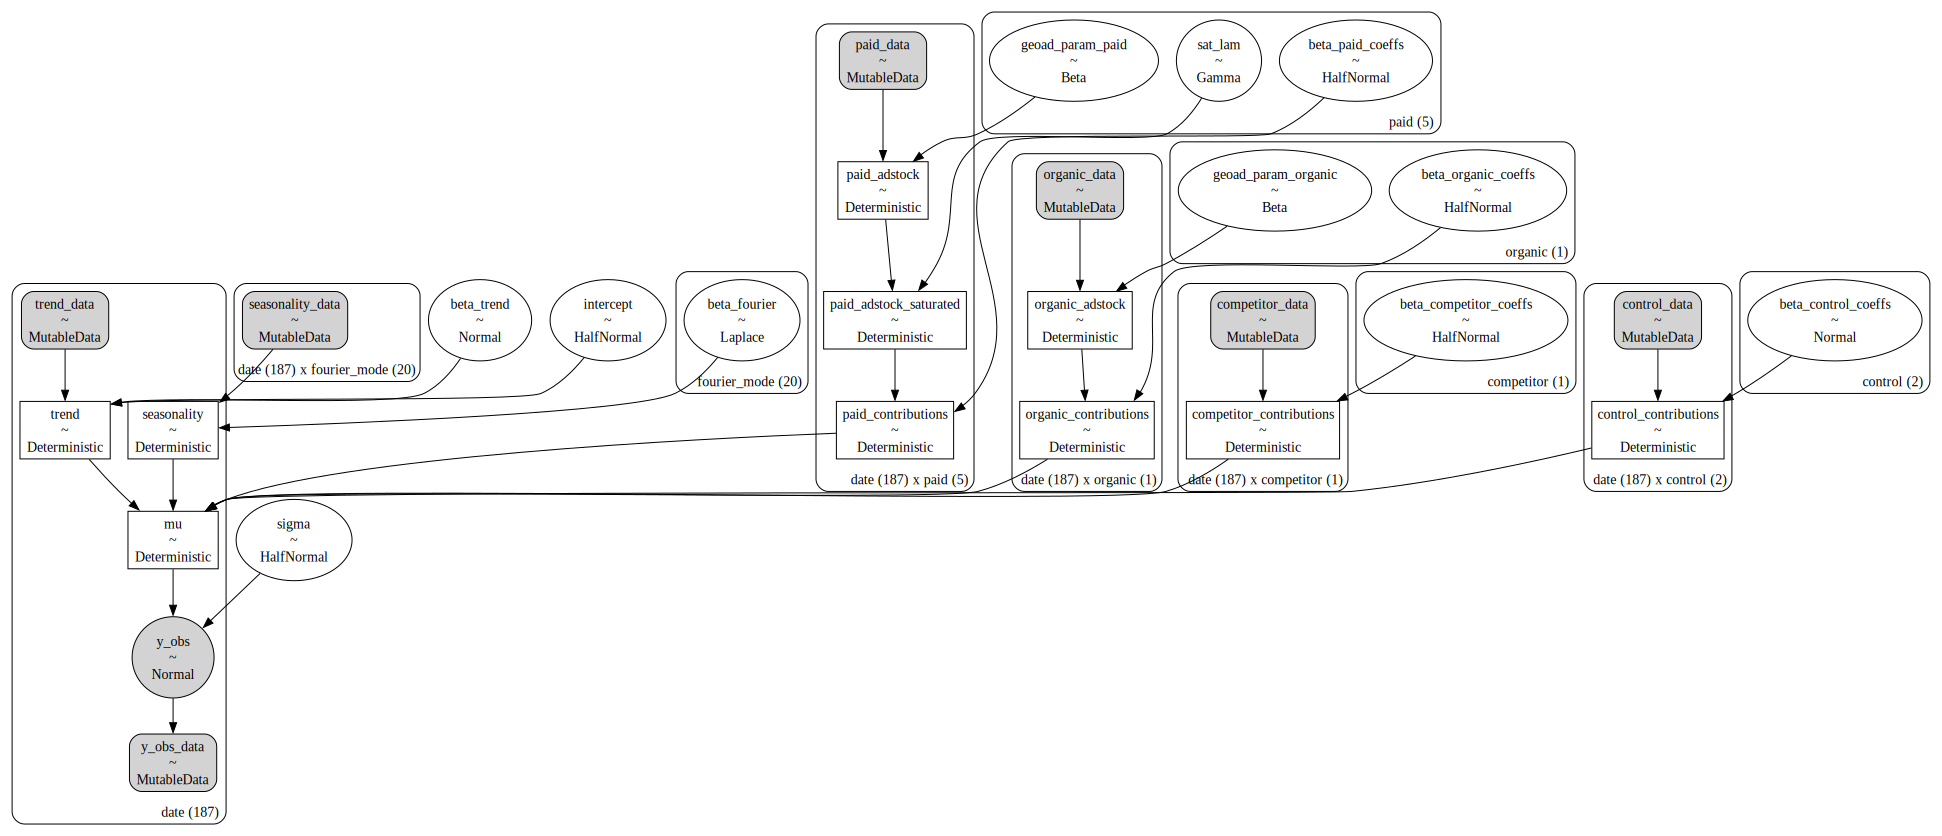

In [12]:
# Plot the structure of the model
pm.model_to_graphviz(model=mmm) 

In [ ]:
# Set seed for this cell
rng = np.random.default_rng(42)

# Fit model 
with mmm:
    # Run MCMC algorithm
    trace = pm.sample(draws=1000, # number of samples to draw from posterior distribution
                      tune=500, # number of burn-in samples, samples that are discarded 
                      chains=4, # number Markov Chains (separate sequences of samples to pull)
                      cores=4, # how many cores to run the model with, defaults to same number of chains
                      target_accept=0.95, # default is 0.8, increasing gives models more chances to not get blocked (stuck in some param space) 
                      random_seed=rng)

    # Sample from posteriors
    mmm_posterior_predictive = pm.sample_posterior_predictive(trace=trace,
                                                              # pass in earlier defined seedd
                                                              random_seed = rng)

    # Calculate elemwise log_likelihood of model given posteriors
    # Used for LOOCV later
    pm.compute_log_likelihood(trace)

## Get Train Posterior Likelihoods and Convert to Revenue

In [ ]:
# Get posterior likelihood, y_obs
train_posterior_predictive_likelihood = az.extract(
    data=mmm_posterior_predictive,
    group="posterior_predictive",
    var_names="y_obs")

# Convert back from AbsMaxScaled value into revenue
train_posterior_predictive_likelihood_inv = endog_scaler.inverse_transform(X=train_posterior_predictive_likelihood)

## Specify Test Model

In [ ]:
# Set seed for this cell
rng = np.random.default_rng(42)

# Update model with test data / dimensions
coords = {"date": X.index}
with mmm:
    pm.set_data({"paid_data": X[FEATURES['features_paid']].to_numpy(),
                 "organic_data": X[FEATURES['features_organic']].to_numpy(),
                 "competitor_data": X[FEATURES['features_competitor']].to_numpy(),
                 "control_data": X[FEATURES['features_control']].to_numpy(),
                 "y_obs_data": y,
                 "trend_data": X["trend_feature"].to_numpy(),
                 "seasonality_data": X[SEASONALITY_CONFIG["seasonality_features"]].to_numpy()
                }, 
                coords=coords
               )
    # Get the predictions using training MMM trace / idata
    # i.e. the trace we had created earlier with training data
    test_mmm_posterior_predictive = pm.sample_posterior_predictive(trace, random_seed = rng, var_names=["y_obs", "organic_contributions", "competitor_contributions",
                                                                                                        "paid_adstock_saturated", "paid_contributions", "control_contributions",
                                                                                                        "trend", "seasonality", "geoad_param_paid", "sat_lam", "paid_adstock", 
                                                                                                        "paid_adstock_saturated", "organic_adstock"])

## Get Test Posterior Likelihoods and Convert to Revenue

In [ ]:
# Get posterior likelihood, y_obs
test_posterior_predictive_likelihood = az.extract(
    data=test_mmm_posterior_predictive,
    group="posterior_predictive",
    var_names="y_obs")

# Convert back from AbsMaxScaled value into CS value
test_posterior_predictive_likelihood_inv = endog_scaler.inverse_transform(X=test_posterior_predictive_likelihood)

In [ ]:
# Get predictions
train_preds = train_posterior_predictive_likelihood_inv.mean(axis=1)
test_preds = test_posterior_predictive_likelihood_inv.mean(axis=1)
# Filter test predictions to be ONLY OVER THE TEST PERIOD!!!!
test_preds = test_preds[y_train.shape[0]:]

## Model over full dataset

In [ ]:
# Get predictions over the entire dataset
y_pred = test_posterior_predictive_likelihood_inv.mean(axis=1)

# Get true and observed target
y_true = df.revenue.copy().to_numpy()

In [ ]:
def nrmse(y_true, y_pred):
    """
    Normalized Root Mean Square Error.
    Args:
        y_true ([np.array]): test samples
        y_pred ([np.array]): predicted samples
    Returns:
        [float]: normalized root mean square error
    """
    return rmse(y_true, y_pred) / (y_true.max() - y_true.min())

# Error metric functions
def rmse(y_true, y_pred):
    """
    Root Mean Square Error
    """
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Create metric dict for mlflow - fill it with NaNs as placeholder values if they metrics can't be calculated
model_metrics = {
    "r_squared_train": np.NaN,
    "r_squared_train_std": np.NaN,
    "r_squared_test": np.NaN,
    "r_squared_test_std": np.NaN,
    "r_squared": np.NaN,
    "rmse_train": np.NaN,
    "rmse_test": np.NaN,
    "rmse": np.NaN,
    "nrmse_train": np.NaN,
    "nrmse_test": np.NaN,
}

# Handle NaNs to allow code to run
try:
    # Calculate Bayesian R-squared
    model_metrics["r_squared_train"] = az.r2_score(unscaled_y_train, train_preds)["r2"]
    model_metrics["r_squared_train_std"] = az.r2_score(unscaled_y_train, train_preds)["r2_std"]
    model_metrics["r_squared_test"] = az.r2_score(unscaled_y_test, test_preds)["r2"]
    model_metrics["r_squared_test_std"] = az.r2_score(unscaled_y_test, test_preds)["r2_std"]
    model_metrics["r_squared"] = az.r2_score(y_true, y_pred)["r2"]
    
    print("Train R-Squared = ", model_metrics["r_squared_train"])
    print("Test R-Squared = ", model_metrics["r_squared_test"])
    print("Full dataset R-Squared = ", model_metrics["r_squared"])
    
    
    # Calculate RMSE
    model_metrics["rmse_train"] = rmse(unscaled_y_train, train_preds)
    model_metrics["rmse_test"] = rmse(unscaled_y_test, test_preds)
    model_metrics["rmse"] = rmse(y_true, y_pred)
    print("")
    print("Train RMSE = ", model_metrics["rmse_train"])
    print("Test RMSE = ", model_metrics["rmse_test"])
    print("Full dataset RMSE = ", model_metrics["rmse"])
    
    # Calculate NRMSE - Robyn metric
    model_metrics["nrmse_train"] = nrmse(unscaled_y_train, train_preds)
    model_metrics["nrmse_test"] = nrmse(unscaled_y_test, test_preds)
    model_metrics["nrmse"] = nrmse(y_true, y_pred)
    print("")
    print("Train NRMSE = ", model_metrics["nrmse_train"])
    print("Test NRMSE = ", model_metrics["nrmse_test"])
    print("Full dataset NRMSE = ", model_metrics["nrmse"])

except ValueError:
    print("Some NaNs were present")

## Model plots

In [ ]:
def plot_predictions_vs_actuals(data_index, actual_data, predictions, dataset_type='Test', title=None):
    """
    Plot predictions against actual data, label axes, and return the figure object.
    
    :param data_index: Index for the x-axis, typically the dates from the dataset.
    :param actual_data: The actual data to be plotted.
    :param predictions: The predicted data to be plotted.
    :param dataset_type: The type of dataset being plotted ('Test' or 'Train').
    :param title: Title for the plot. If None, a default title is generated based on dataset_type.
    :return: The matplotlib figure object.
    """
    if title is None:
        title = f"{dataset_type} Set | Predictions vs Actuals"

    f, ax = plt.subplots(figsize=(12, 8))
    ax.set_title(title)
    ax.plot(data_index, actual_data, label="Actual Revenue", marker='o')
    ax.plot(data_index, predictions, label="Pred Revenue", marker='x')
    ax.set_xlabel("Date")
    ax.set_ylabel("Revenue")
    ax.legend()
    plt.show()
    
    return f

In [ ]:
# Plot predictions vs actuals
train_plot = plot_predictions_vs_actuals(X_train.index, unscaled_y_train, train_preds, dataset_type="Train")
test_plot = plot_predictions_vs_actuals(X_test.index, unscaled_y_test, test_preds, dataset_type="Test")